In [1]:
import ast
import mlflow
import gymnasium as gym
import numpy as np
import pandas as pd
from imitation.algorithms.adversarial.airl import AIRL
from imitation.rewards.reward_nets import BasicShapedRewardNet
from imitation.util.networks import RunningNorm
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.util.util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecCheckNan
from imitation.data import rollout, serialize
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.algorithms.adversarial.airl import AIRL
from imitation.data import rollout, serialize
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.util.util import make_vec_env
from matplotlib.dates import DateFormatter
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecCheckNan
from stable_baselines3.ppo import MlpPolicy
from imitation.data.rollout import flatten_trajectories
from imitation.data.types import Trajectory
import gymnasium as gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import SAC
from stable_baselines3.common.logger import HumanOutputFormat, KVWriter, Logger
import mlflow


from graph_reinforcement_learning_using_blockchain_data import config
from graph_reinforcement_learning_using_blockchain_data.modeling import rl

config.load_dotenv()
mlflow.set_tracking_uri(uri=config.MLFLOW_TRACKING_URI)


2025-04-02 16:54:45.627 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:11 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


In [2]:
df_emb = pd.read_csv(config.FLASHBOTS_Q2_DATA_DIR / "state_embeddings.csv")
df_class0 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class0.csv")
df_class1 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class1.csv")

In [3]:
df_emb["embeddings"] = df_emb["embeddings"].apply(lambda x: np.array(ast.literal_eval(x), dtype=np.float32))

In [4]:
df_class0["label"] = 0
df_class1["label"] = 1

In [5]:
df_receipts = pd.concat([df_class0, df_class1], ignore_index=True)
df_receipts.drop_duplicates("transaction_hash", inplace=True)
df = df_receipts.merge(df_emb, how="right", left_on="transaction_hash", right_on="transactionHash")

In [6]:
df.head()

,block_number,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,created_at,account_address,profit_token_address,start_amount,end_amount,profit_amount,error,protocols,transactionHash,embeddings
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[-1.0455092, -0.45075172, -1.2988981, 0.689674..."
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-6.1341934, -4.090339, -6.813894, 2.9215977, ..."
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-5.403815, -3.6793585, -6.4153795, 2.0699742,..."
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-7.711429, -5.4846554, -9.181214, 2.5007846, ..."
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-10.870382, -8.408549, -12.329528, 6.705676, ..."


In [7]:
ser_median_gas_prices = pd.DataFrame({"median_gas_price": df.groupby(["block_number"])["effectiveGasPrice"].median()})
df_with_median_gas_prices = df.merge(ser_median_gas_prices, how="left", on="block_number")
df_with_median_gas_prices.head()

,block_number,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,account_address,profit_token_address,start_amount,end_amount,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[-1.0455092, -0.45075172, -1.2988981, 0.689674...",2.841278e+10
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-6.1341934, -4.090339, -6.813894, 2.9215977, ...",3.132425e+10
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-5.403815, -3.6793585, -6.4153795, 2.0699742,...",4.701599e+10
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-7.711429, -5.4846554, -9.181214, 2.5007846, ...",3.997607e+10
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-10.870382, -8.408549, -12.329528, 6.705676, ...",2.695208e+10


In [8]:
df_with_actions = df_with_median_gas_prices.copy()
df_with_actions["action"] = df_with_median_gas_prices.apply(
    lambda r: 1 if r["effectiveGasPrice"] > r["median_gas_price"] else 0, axis=1)

In [9]:
df_with_actions["action"].mean()

0.24449359876667337

In [10]:
df_with_actions.head()

,block_number,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_token_address,start_amount,end_amount,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,action
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[-1.0455092, -0.45075172, -1.2988981, 0.689674...",2.841278e+10,1
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-6.1341934, -4.090339, -6.813894, 2.9215977, ...",3.132425e+10,1
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-5.403815, -3.6793585, -6.4153795, 2.0699742,...",4.701599e+10,1
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-7.711429, -5.4846554, -9.181214, 2.5007846, ...",3.997607e+10,0
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-10.870382, -8.408549, -12.329528, 6.705676, ...",2.695208e+10,1


In [11]:
def extract_trajectories(df: pd.DataFrame):
    trajectories = []
    for account, group in df.groupby("from"):
        group = group.sort_values("blockNumber")
        obs_list = group["embeddings"].tolist() + [np.zeros(128, dtype=np.float32)]
        traj = {
            "obs": np.stack(obs_list),  # Convert list of arrays to a single numpy array
            "acts": np.array(group["action"].tolist()),
            "label": group["label"].iloc[0],
        }
        trajectories.append(traj)
    return trajectories


trajectories = extract_trajectories(df_with_actions)
trajectories = [Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True) for traj in
                trajectories]

In [12]:
print(trajectories[0:2])

[Trajectory(obs=array([[ -1.0455092 ,  -0.45075172,  -1.2988981 , ...,   0.81318885,
         -0.7551223 ,   0.8297794 ],
       [ -6.1341934 ,  -4.090339  ,  -6.813894  , ...,   5.805883  ,
         -3.395713  ,   4.4144816 ],
       [ -5.403815  ,  -3.6793585 ,  -6.4153795 , ...,   5.13811   ,
         -3.2854714 ,   3.600047  ],
       ...,
       [-12.986318  , -10.386331  , -12.84005   , ...,  15.895627  ,
         -5.5778017 ,  10.164024  ],
       [-11.753667  ,  -9.874844  , -11.97616   , ...,  13.794137  ,
         -4.841109  ,   9.373998  ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]], dtype=float32), acts=array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0]), infos=None, terminal=True), Trajectory(obs=array([[  3.2502105,   3.2609775,   2.707357 , ...,  -2.0959454,
         -0.367815 ,  -3.865498 ],
       [  6.131294 ,  10.828458 ,   5.341215 , ...,  -6.881277 ,
          1.992177 ,  -9.407136 ],
       [  7.1093006,  13.3111

In [13]:
# trajectories_arbitrage = [traj for traj in trajectories if traj["label"] == 1]
# trajectories_nonarb = [traj for traj in trajectories if traj["label"] == 0]

In [14]:
# from imitation.data.rollout import flatten_trajectories
# from imitation.data.types import Trajectory
# 
# trajectories_arbitrage = [Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True) for traj in
#                           trajectories_arbitrage]
# trajectories_0 = [Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True) for traj in
#                           trajectories_nonarb]
# 
# trajectories_arbitrage = flatten_trajectories(trajectories_arbitrage)

In [158]:
class TransactionGraphEnv(gym.Env):
    def __init__(
            self,
            df: pd.DataFrame,
            alpha: float,
    ):
        self.df = df.copy()
        self.accounts = df["from"].unique()
        self.account_index = None
        self.transaction_index = None
        self.alpha = alpha
        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(128,),
            dtype=np.float32,
        )
        self.action_space = gym.spaces.Discrete(2)
        self.current_trajectory = None
        self.current_account_transactions = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.account_index = np.random.randint(0, len(self.accounts))
        self.transaction_index = 0
        self.current_trajectory = []
        self.current_account_transactions = self.df[self.df["from"] == self.accounts[self.account_index]]
        self.current_account_transactions = self.current_account_transactions.sort_values(by=["blockNumber"])
        return self._get_observation(), {}

    def _get_observation(self):
        if self.transaction_index >= len(self.current_account_transactions):
            return np.zeros(self.observation_space.shape, dtype=np.float32)
        
        obs = self.current_account_transactions.iloc[self.transaction_index]["embeddings"]
        obs = np.array(obs, dtype=np.float32)
        return obs

    def step(self, action):
        obs = self._get_observation()
        # If this is the first transaction, there's no previous action to compare.
        if self.transaction_index == 0:
            reward = 0  # or some default reward
        else:
            # Compute reward based on the previous transaction's expert action.
            current_tx = self.current_account_transactions.iloc[self.transaction_index - 1]
            # print(current_tx["transaction_hash"])
            # print(current_tx["from"])
            actual_action = current_tx["action"]
            reward = 1.0 if action == actual_action else -1.0

        self.current_trajectory.append((obs, action))
        self.transaction_index += 1
        
        done = False
        info = {}
        if self.transaction_index >= len(self.current_account_transactions):
            done = True

            # metadata
            last_tx = self.current_account_transactions.iloc[self.transaction_index - 1]
            info = {
                "from": self.accounts[self.account_index],
                "num_transactions": self.transaction_index,
                "last_block": last_tx["blockNumber"],
                "trajectory": self.current_trajectory,
            }

            # move to next account
            self.account_index += 1
            self.transaction_index = 0
            if self.account_index < len(self.accounts):
                self.current_account_transactions = self.df[self.df["from"] == self.accounts[self.account_index]]
                self.current_account_transactions = self.current_account_transactions.sort_values(by=["blockNumber"])
            else:
                done = True

        next_obs = self._get_observation()
        return next_obs, reward, done, False, info

In [159]:
ID = "gymnasium_env/TransactionGraphEnv-v0"
gym.envs.register(
    id=ID,
    entry_point=TransactionGraphEnv,
    kwargs={"df": df_with_actions, "alpha": 0.9},
    max_episode_steps=300
)

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment gymnasium_env/TransactionGraphEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [160]:
gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v2
LunarLander-v2         LunarLanderContinuous-v2
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
HalfCheetah-v2         HalfCheetah-v3         HalfCheetah-v4
Hopper-v2              Hopper-v3              Hopper-v4
Humanoid-v2            Humanoid-v3            Humanoid-v4
HumanoidStandup-v2     HumanoidStandup-v4     InvertedDoublePendulum-v2
InvertedDoublePendulum-v4 InvertedPendulum-v2    InvertedPendulum-v4
Pusher-v2              Pusher-v4              Reacher-v2
Reacher-v4         

In [161]:
env = Monitor(gym.make(ID))

venv = make_vec_env(
    ID,
    rng=np.random.default_rng(seed=42),
    n_envs=1,
    post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],
    parallel=False,
)

venv = VecCheckNan(venv, raise_exception=True)  # Check for NaN observations
venv.reset()

array([[-1.0219446 , -0.44008672, -1.268946  ,  0.6761698 , -1.0916852 ,
         1.7125977 ,  0.78753096, -0.97603333, -0.8762395 ,  1.120952  ,
        -0.0923164 ,  0.15675327,  0.29411864,  0.35224983, -1.2907144 ,
        -1.0897238 , -0.73787534,  1.3057315 ,  0.99601954,  1.3786213 ,
        -0.14266959,  0.49921075,  0.16870394,  0.47060972, -1.2903812 ,
        -0.79140025,  0.6080115 , -0.9563403 ,  0.9924938 ,  0.59639883,
        -1.0983481 ,  0.64098305,  1.1640006 , -0.64152104,  1.0791329 ,
         0.18382238,  1.6783425 ,  0.80833066,  0.76641923,  0.00530105,
        -0.16984698,  1.1901253 , -0.24076802,  0.16441134, -1.3872895 ,
        -0.4225966 ,  0.62044734,  0.8274153 ,  0.8240976 ,  1.2699511 ,
         0.44835553, -0.11089998,  0.9814248 , -0.9351972 ,  0.7031022 ,
        -0.9284731 ,  0.8272879 , -0.880919  , -1.2518903 ,  0.72590214,
         1.2381841 ,  0.5673545 , -0.8900562 , -1.5772257 , -0.5269868 ,
        -1.2402561 ,  0.5867689 , -1.9187392 ,  0.1

In [162]:
# Set parameters for the rollout
min_timesteps = None
min_episodes = 1

# Rollout the environment with a random policy
rollouts = rollout.rollout(
    None,  # Random policy
    venv,
    sample_until=rollout.make_sample_until(
        min_timesteps=min_timesteps, min_episodes=min_episodes
    ),
    rng=np.random.default_rng(seed=42),
)

# Print the first rollout
for i in range(len(rollouts[0].obs) - 1):
    print("Observation: ", rollouts[0].obs[i])
    print("Action: ", rollouts[0].acts[i])
    print()

Observation:  [-23.047815   -14.219875   -21.581516    10.521314   -18.231833
  18.802017    24.835762   -32.47229    -19.917671    26.812284
  -7.388303    14.401051    16.576418    -3.753118   -20.335
 -15.762381   -16.715363    27.323189    32.38644     21.125061
 -13.108816    -4.0295157    3.6854563    9.381119   -24.133677
 -18.590525    24.549105   -28.71291     11.025675    20.542469
 -26.88783     26.784248   -12.483289    -6.36665     25.917084
   3.8060315    0.47548276  24.381073    21.926208     2.7745156
   2.4466484   24.934275    -3.2342775  -20.393074   -32.304504
   0.1072409    4.223062    25.937157    28.883232    23.574566
  -5.6211324  -15.474777    -7.2084837   -7.7416506   32.46985
   0.98230076  11.449383     7.8720856  -37.897907    25.055798
   1.852053    18.730644   -19.79129    -22.540398    14.552744
 -20.366646    -2.5924888  -25.862001   -25.655968   -21.571127
  16.076397    18.085941    -9.238968    17.666672    18.662086
 -16.532314   -20.596388   -1

In [163]:
class RandomPolicy:
    """Random policy."""

    def __init__(self, action_space: gym.spaces.Space) -> None:
        """
        Initialize the random policy.

        Args:
            action_space: Action space of the environment.
        """
        self.action_space = action_space

    def predict(self, obs, state, *args, **kwargs) -> tuple:
        """
        Get the random actions for the given observations, states and dones.

        Args:
            obs: Observations of the environment.
            state: States.
            args: Additional arguments.
            kwargs: Additional keyword arguments.

        Returns:
            Actions and states.
        """
        return np.array([self.action_space.sample()]), state


# Initialize the random policy
random_policy = RandomPolicy(venv.action_space)

venv.seed(1)
# Evaluate the random policy
reward_random_policy, _ = evaluate_policy(
    random_policy, venv, 4, return_episode_rewards=True
)
print("Reward of the random policy")
print("---------------------------")
print("Reward: ", np.mean(reward_random_policy))
print("Std:    ", np.std(reward_random_policy))

Reward of the random policy
---------------------------
Reward:  -0.25
Std:     1.299038105676658


In [164]:
# df_0 = df_with_actions[df_with_actions["action"] == 0]
# df_1 = df_with_actions[df_with_actions["action"] == 1]
# 
# unique_blocks0 = np.sort(df_0["blockNumber"].unique())
# unique_blocks1 = np.sort(df_1["blockNumber"].unique())
# 
# split_index0 = int(0.8 * len(unique_blocks0))
# split_index1 = int(0.8 * len(unique_blocks1))
# 
# train_blocks0 = unique_blocks0[:split_index0]
# test_blocks0 = unique_blocks0[split_index0:]
# train_blocks1 = unique_blocks1[:split_index1]
# test_blocks1 = unique_blocks1[split_index1:]
# 
# df_train0 = df_0[df_0["blockNumber"].isin(train_blocks0)]
# df_test0 = df_0[df_0["blockNumber"].isin(test_blocks0)]
# df_train1 = df_1[df_1["blockNumber"].isin(train_blocks1)]
# df_test1 = df_1[df_1["blockNumber"].isin(test_blocks1)]
# 
# print(f"Train blocks 0: {len(train_blocks0)}, Test blocks 0: {len(test_blocks0)}")
# print(f"Train blocks 1: {len(train_blocks1)}, Test blocks 1: {len(test_blocks1)}")
# 
# alpha = 0.3
# 
# train_env0 = TransactionGraphEnv(df_train0, alpha)
# train_env1 = TransactionGraphEnv(df_train1, alpha)
# test_env0 = TransactionGraphEnv(df_test0, alpha)
# test_env1 = TransactionGraphEnv(df_test1, alpha)
# 
# # train_env_flat = gym.wrappers.FlattenObservation(train_env)
# # test_env_flat = gym.wrappers.FlattenObservation(test_env)
# 
# train_env0 = Monitor(train_env0)
# test_env0 = Monitor(test_env0)
# train_env1 = Monitor(train_env1)
# test_env1 = Monitor(test_env1)
# 
# check_env(train_env0)
# check_env(test_env0)
# check_env(test_env1)
# check_env(test_env1)
# 
# vec_train_env0 = DummyVecEnv([lambda: train_env0])
# vec_test_env0 = DummyVecEnv([lambda: test_env0])
# vec_train_env1 = DummyVecEnv([lambda: train_env1])
# vec_test_env1 = DummyVecEnv([lambda: test_env1])

In [165]:
# Set parameters for the PPO algorithm (generator)
learning_rate = 0.001  # Learning rate, can be a function of progress
batch_size = 60  # Mini batch size for each gradient update
n_epochs = 15  # N of epochs when optimizing the surrogate loss

gamma = 0.5  # Discount factor, focus on the recent rewards
gae_lambda = 0  # Generalized advantage estimation
clip_range = 0.1  # Clipping parameter
ent_coef = 0.01  # Entropy coefficient for the loss calculation
vf_coef = 0.5  # Value function coef. for the loss calculation
max_grad_norm = 0.5  # The maximum value for the gradient clipping

verbose = 0  # Verbosity level: 0 no output, 1 info, 2 debug
normalize_advantage = True  # Whether to normalize or not the advantage

clip_range_vf = None  # Clip for the value function
use_sde = False  # Use State Dependent Exploration
sde_sample_freq = -1  # SDE - noise matrix frequency (-1 = disable)

# Set parameters for the AIRL trainer
gen_replay_buffer_capacity = None
allow_variable_horizon = True

disc_opt_kwargs = {
    "lr": 0.001,
}
policy_kwargs = {"use_expln": True}  # Fixing an issue with NaNs


In [166]:
# Set the number of timesteps, batch size and number of disc updates

# Total number of timesteps in the whole training
total_timesteps = 3000 * 10

# Generator
gen_train_timesteps = 3000  # N steps in the environment per one round
n_steps = gen_train_timesteps

# Discriminator batches
demo_minibatch_size = 60  # N samples in minibatch for one discrim. update
demo_batch_size = 300 * 10  # N samples in the batch of expert data (batch)
n_disc_updates_per_round = 4  # N discriminator updates per one round

In [167]:
# Initialize the learner PPO policy (generator)
learner = PPO(
    env=venv,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

In [168]:
reward_net = BasicShapedRewardNet(
    observation_space=venv.observation_space,
    action_space=venv.action_space,
    normalize_input_layer=RunningNorm,
)

# Initialize the AIRL trainer
airl_trainer = AIRL(
    demonstrations=trajectories,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


In [169]:
# reward_net = BasicShapedRewardNet(
#     observation_space=vec_train_env0.observation_space,
#     action_space=vec_train_env0.action_space,
#     normalize_input_layer=RunningNorm,
# )
# 
# gen_algo = PPO(
#     env=vec_train_env0,
#     policy="MlpPolicy",
#     batch_size=64,
#     ent_coef=0.0,
#     learning_rate=0.0005,
#     gamma=0.95,
#     clip_range=0.1,
#     vf_coef=0.1,
#     n_epochs=5,
#     seed=42,
# )
# 
# irl_arbitrage = AIRL(
#     demonstrations=trajectories_0,
#     demo_batch_size=2048,
#     gen_replay_buffer_capacity=512,
#     n_disc_updates_per_round=16,
#     venv=vec_train_env0,
#     gen_algo=gen_algo,
#     reward_net=reward_net,
#     allow_variable_horizon=True
# )

In [213]:
from stable_baselines3.common.evaluation import evaluate_policy
venv.seed(1)

learner_rewards_before_training, _ = evaluate_policy(
    learner, venv, 2, return_episode_rewards=True
)

print("Reward of the learner policy before training")
print("--------------------------------------------")
print("Mean: ", np.mean(learner_rewards_before_training))
print("Std: ", np.std(learner_rewards_before_training))

Reward of the learner policy before training
--------------------------------------------
Mean:  30.5
Std:  31.5


In [171]:
for _ in range(10):
        obs = venv.reset()
        done = False
        while not done:
            print(obs)
            action, _ = learner.predict(obs, deterministic=True)
            print(action)
            print()
            obs, _, done, _ = venv.step(action)

[[-9.67071474e-01 -4.15252864e-01 -1.19919825e+00  6.44722223e-01
  -1.03406537e+00  1.62214124e+00  7.40969241e-01 -9.19896603e-01
  -8.26703191e-01  1.06311882e+00 -8.42752978e-02  1.44689173e-01
   2.77603090e-01  3.37553024e-01 -1.22203481e+00 -1.03328466e+00
  -6.99171185e-01  1.23357475e+00  9.45071518e-01  1.30665970e+00
  -1.30517825e-01  4.73925710e-01  1.63727105e-01  4.48161066e-01
  -1.22070765e+00 -7.50591040e-01  5.71322978e-01 -9.04623151e-01
   9.39921618e-01  5.61285377e-01 -1.03717053e+00  6.05942369e-01
   1.10600173e+00 -6.07046187e-01  1.02328408e+00  1.74673155e-01
   1.58898926e+00  7.63648868e-01  7.26035953e-01  1.75842270e-03
  -1.58277363e-01  1.12109160e+00 -2.26171523e-01  1.60443455e-01
  -1.31738997e+00 -3.96232188e-01  5.89045346e-01  7.82747984e-01
   7.80155301e-01  1.19902515e+00  4.28495675e-01 -1.03180774e-01
   9.31623220e-01 -8.85116100e-01  6.65278435e-01 -8.80652070e-01
   7.81632543e-01 -8.36611092e-01 -1.18587494e+00  6.83781624e-01
   1.17501

In [172]:
airl_trainer.train(total_timesteps=total_timesteps)

round:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 3.84     |
|    gen/rollout/ep_rew_mean  | -0.06    |
|    gen/time/fps             | 172      |
|    gen/time/iterations      | 1        |
|    gen/time/time_elapsed    | 17       |
|    gen/time/total_timesteps | 3000     |
------------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.596    |
|    disc/disc_loss                   | 0.0164   |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 60       |
|    disc/n_generated                 | 60       |
-

round:  10%|█         | 1/10 [00:24<03:40, 24.53s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 7.32         |
|    gen/rollout/ep_rew_mean         | -0.32        |
|    gen/rollout/ep_rew_wrapped_mean | 6.98         |
|    gen/time/fps                    | 156          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 19           |
|    gen/time/total_timesteps        | 6000         |
|    gen/train/approx_kl             | 0.0022298775 |
|    gen/train/clip_fraction         | 0.05         |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.692       |
|    gen/train/explained_variance    | -0.0873      |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 4.43         |
|    gen/train/n_updates             | 15           |
|    gen/train/policy_gradient_loss  | -4.9e-05     |
|    gen/train/value_loss   

round:  20%|██        | 2/10 [00:51<03:29, 26.24s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 12.2         |
|    gen/rollout/ep_rew_mean         | 0.05         |
|    gen/rollout/ep_rew_wrapped_mean | 0.956        |
|    gen/time/fps                    | 162          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 18           |
|    gen/time/total_timesteps        | 9000         |
|    gen/train/approx_kl             | 0.0013154699 |
|    gen/train/clip_fraction         | 0.106        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.688       |
|    gen/train/explained_variance    | -2.24        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.611        |
|    gen/train/n_updates             | 30           |
|    gen/train/policy_gradient_loss  | 0.000727     |
|    gen/train/value_loss   

round:  30%|███       | 3/10 [01:17<03:02, 26.03s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 7.33         |
|    gen/rollout/ep_rew_mean         | 0.03         |
|    gen/rollout/ep_rew_wrapped_mean | 0.694        |
|    gen/time/fps                    | 179          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 16           |
|    gen/time/total_timesteps        | 12000        |
|    gen/train/approx_kl             | 0.0019211695 |
|    gen/train/clip_fraction         | 0.16         |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.685       |
|    gen/train/explained_variance    | 0.189        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0336       |
|    gen/train/n_updates             | 45           |
|    gen/train/policy_gradient_loss  | -0.00179     |
|    gen/train/value_loss   

round:  40%|████      | 4/10 [01:41<02:30, 25.15s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.5         |
|    gen/rollout/ep_rew_mean         | 0.3         |
|    gen/rollout/ep_rew_wrapped_mean | -1.87       |
|    gen/time/fps                    | 175         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 17          |
|    gen/time/total_timesteps        | 15000       |
|    gen/train/approx_kl             | 0.004894882 |
|    gen/train/clip_fraction         | 0.109       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.683      |
|    gen/train/explained_variance    | 0.212       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0848      |
|    gen/train/n_updates             | 60          |
|    gen/train/policy_gradient_loss  | -0.00258    |
|    gen/train/value_loss            | 0.709  

round:  50%|█████     | 5/10 [02:06<02:05, 25.03s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 9.22         |
|    gen/rollout/ep_rew_mean         | 1.06         |
|    gen/rollout/ep_rew_wrapped_mean | -2.98        |
|    gen/time/fps                    | 187          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 16           |
|    gen/time/total_timesteps        | 18000        |
|    gen/train/approx_kl             | 0.0028903154 |
|    gen/train/clip_fraction         | 0.15         |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.675       |
|    gen/train/explained_variance    | 0.623        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.453        |
|    gen/train/n_updates             | 75           |
|    gen/train/policy_gradient_loss  | -0.00383     |
|    gen/train/value_loss   

round:  60%|██████    | 6/10 [02:29<01:37, 24.37s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.5          |
|    gen/rollout/ep_rew_mean         | 0.38         |
|    gen/rollout/ep_rew_wrapped_mean | -3.04        |
|    gen/time/fps                    | 161          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 18           |
|    gen/time/total_timesteps        | 21000        |
|    gen/train/approx_kl             | 0.0056310217 |
|    gen/train/clip_fraction         | 0.381        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.652       |
|    gen/train/explained_variance    | 0.644        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0249       |
|    gen/train/n_updates             | 90           |
|    gen/train/policy_gradient_loss  | -0.0133      |
|    gen/train/value_loss   

round:  70%|███████   | 7/10 [02:55<01:14, 24.78s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.33         |
|    gen/rollout/ep_rew_mean         | 0.69         |
|    gen/rollout/ep_rew_wrapped_mean | -2.84        |
|    gen/time/fps                    | 173          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 17           |
|    gen/time/total_timesteps        | 24000        |
|    gen/train/approx_kl             | 0.0098259635 |
|    gen/train/clip_fraction         | 0.479        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.591       |
|    gen/train/explained_variance    | 0.752        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.00326      |
|    gen/train/n_updates             | 105          |
|    gen/train/policy_gradient_loss  | -0.014       |
|    gen/train/value_loss   

round:  80%|████████  | 8/10 [03:19<00:49, 24.67s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 8.29        |
|    gen/rollout/ep_rew_mean         | 1.65        |
|    gen/rollout/ep_rew_wrapped_mean | -2.93       |
|    gen/time/fps                    | 176         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 17          |
|    gen/time/total_timesteps        | 27000       |
|    gen/train/approx_kl             | 0.005642821 |
|    gen/train/clip_fraction         | 0.377       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.597      |
|    gen/train/explained_variance    | 0.67        |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0896      |
|    gen/train/n_updates             | 120         |
|    gen/train/policy_gradient_loss  | -0.0129     |
|    gen/train/value_loss            | 0.193  

round:  90%|█████████ | 9/10 [03:43<00:24, 24.46s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 12         |
|    gen/rollout/ep_rew_mean         | 1.49       |
|    gen/rollout/ep_rew_wrapped_mean | -5.16      |
|    gen/time/fps                    | 202        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 14         |
|    gen/time/total_timesteps        | 30000      |
|    gen/train/approx_kl             | 0.01924498 |
|    gen/train/clip_fraction         | 0.52       |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.493     |
|    gen/train/explained_variance    | 0.786      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.00199    |
|    gen/train/n_updates             | 135        |
|    gen/train/policy_gradient_loss  | -0.0224    |
|    gen/train/value_loss            | 0.152      |
------------

round: 100%|██████████| 10/10 [04:05<00:00, 24.52s/it]


In [201]:
venv.seed(1)
learner_rewards_after_training, _ = evaluate_policy(
    learner, venv, 5, return_episode_rewards=True,
)
print("Reward of the learner policy after training")
print("-------------------------------------------")
print("Mean: ", np.mean(learner_rewards_after_training))
print("Std: ", np.std(learner_rewards_after_training))

Reward of the learner policy after training
-------------------------------------------
Mean:  0.8
Std:  0.9797958971132713


In [175]:
stats = airl_trainer.logger._logger.stats

In [176]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec


def visualize_airl_train_stats(
    train_stats: dict, save_fig: bool = False
) -> None:
    """
    Visualize the training statistics of the AIRL trainer.

    Args:
        train_stats: Training statistics.
        save_fig: Whether to save figures.
    """
    figsize_disc = (12, 18)
    figsize_gen = (12, 18)

    # --------------------------------------------------
    # Discriminator plot
    # --------------------------------------------------
    fig = plt.figure(figsize=figsize_disc)
    gs = GridSpec(4, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])
    ax6 = fig.add_subplot(gs[3, 0])
    ax7 = fig.add_subplot(gs[3, 1])

    # Discriminator loss
    ax1.plot(train_stats["mean/disc/disc_loss"])
    ax1.set_title("Discriminator loss")

    # Discriminator accuracy
    ax2.plot(train_stats["mean/disc/disc_acc"])
    ax2.set_title("Discriminator accuracy")

    # Discriminator entropy
    ax3.plot(train_stats["mean/disc/disc_entropy"])
    ax3.set_title("Discriminator entropy")

    # Discriminator accuracy (expert)
    ax4.plot(train_stats["mean/disc/disc_acc_expert"])
    ax4.set_title("Discriminator accuracy (expert)")

    # Discriminator accuracy (generator)
    ax5.plot(train_stats["mean/disc/disc_acc_gen"])
    ax5.set_title("Discriminator accuracy (generator)")

    # Discriminator expert proportion (true)
    ax6.plot(train_stats["mean/disc/disc_proportion_expert_true"])
    ax6.set_title("Proportion of expert actions (true)")

    # Discriminator expert proportion (predicted)
    ax7.plot(train_stats["mean/disc/disc_proportion_expert_pred"])
    ax7.set_title("Proportion of expert actions (predicted)")

    fig.tight_layout()
    if save_fig:
        fig.savefig("figures/disc_train_stats.pdf")

    # --------------------------------------------------
    # Generator plot
    # --------------------------------------------------
    fig = plt.figure(figsize=figsize_gen)
    gs = GridSpec(4, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    # ax2 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])
    ax6 = fig.add_subplot(gs[3, 0])
    ax7 = fig.add_subplot(gs[3, 1])

    # Generator loss
    ax1.plot(train_stats["mean/gen/train/loss"])
    ax1.set_title("Generator loss")

    # Generator entropy loss
    ax2.plot(train_stats["mean/gen/train/entropy_loss"])
    ax2.set_title("Generator entropy loss")

    # Generator explained variance
    ax3.plot(np.clip(train_stats["mean/gen/train/explained_variance"], -1, 1))
    ax3.set_title("Generator explained variance")

    # Generator value loss
    ax4.plot(train_stats["mean/gen/train/value_loss"])
    ax4.set_title("Generator value loss")

    # Generator policy gradient loss
    ax5.plot(train_stats["mean/gen/train/policy_gradient_loss"])
    ax5.set_title("Generator policy gradient loss")

    # Generator clip fraction
    ax6.plot(train_stats["mean/gen/train/clip_fraction"])
    ax6.set_title("Generator clip fraction")

    # Generator approx kl
    ax7.plot(train_stats["mean/gen/train/approx_kl"])
    ax7.set_title("Generator approximate Kullback-Leibler div")

    fig.tight_layout()
    # fig.show()

    # Save figure
    if save_fig:
        fig.savefig("figures/gen_train_stats.pdf")

    fig = plt.figure(figsize=(12, 4))
    plt.plot(train_stats["mean/gen/rollout/ep_rew_mean"])
    # Set y-axis limits
    # plt.ylim(0, 310)
    plt.title("Mean episode reward")
    if save_fig:
        fig.savefig("figures/mean_ep_rew.pdf")

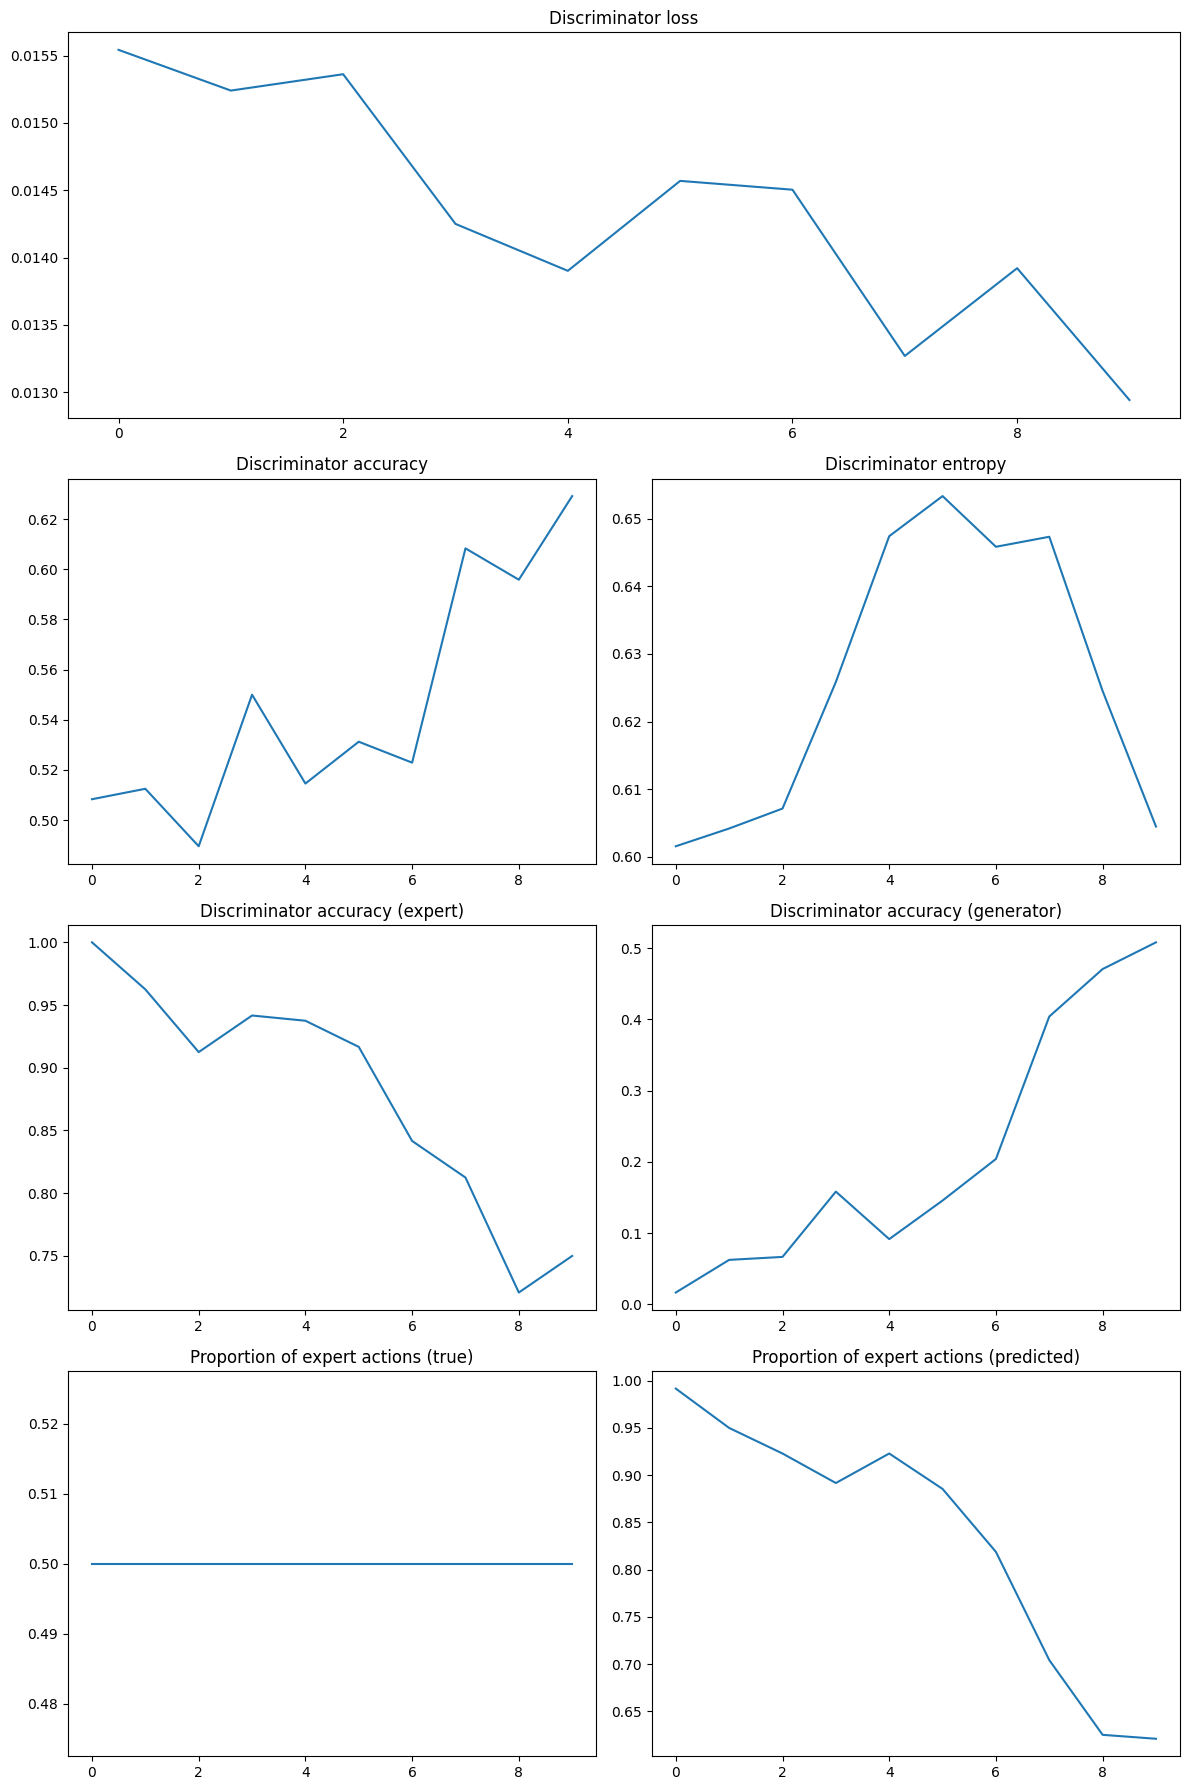

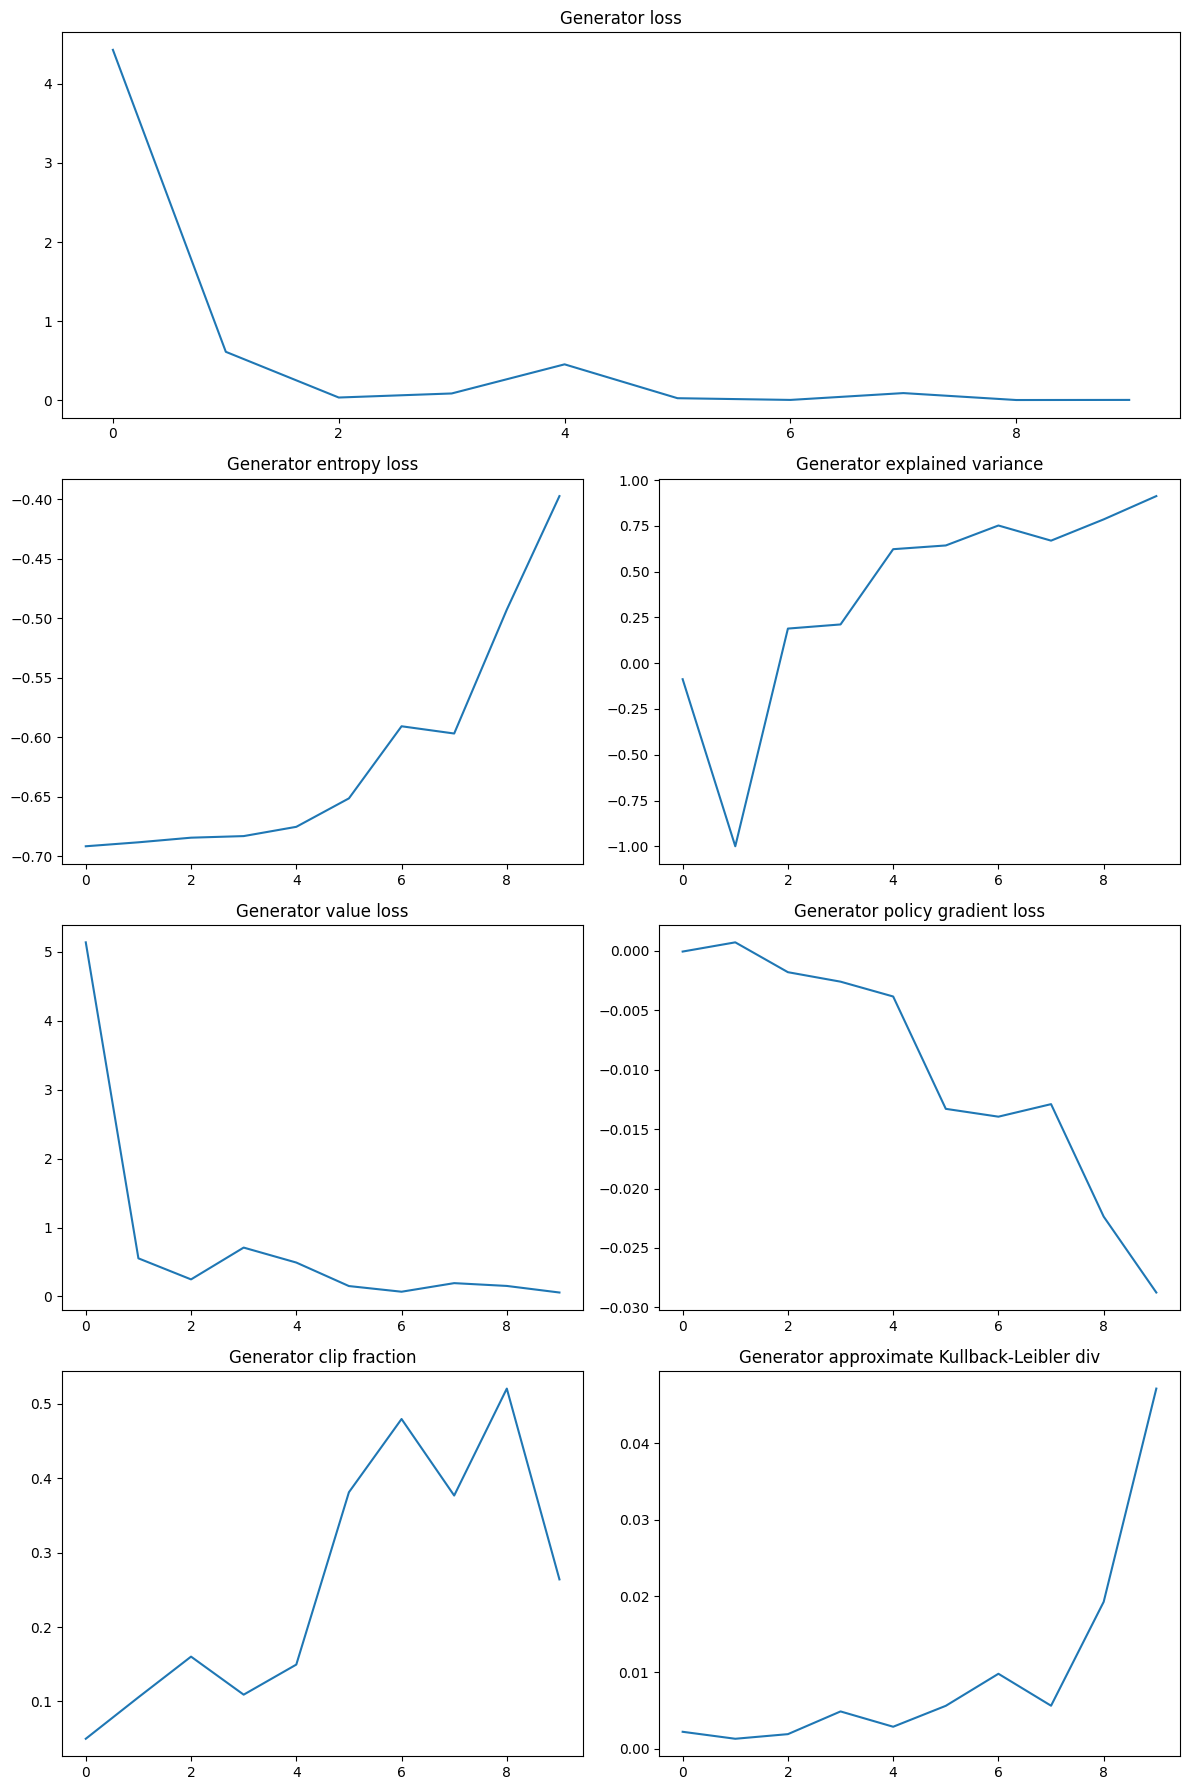

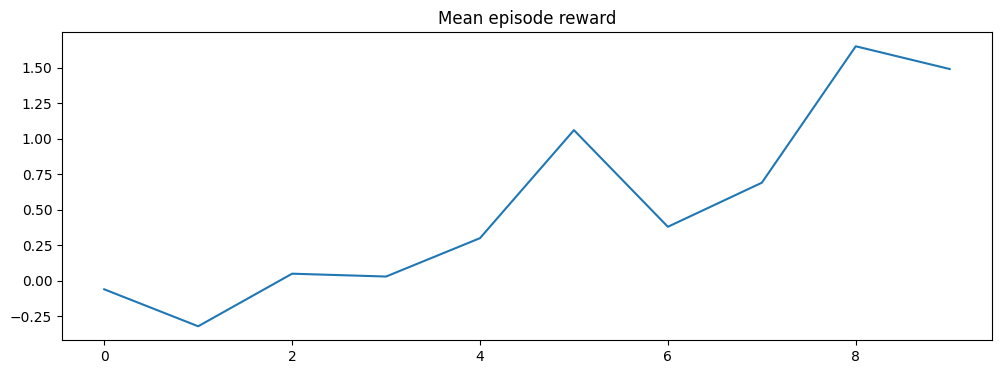

In [177]:
visualize_airl_train_stats(stats)